In [1]:
import numpy as np
import pandas as pd
from pandas.plotting import scatter_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split, cross_val_score, KFold, cross_val_score 
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.base import clone
from sklearn import linear_model
#silence future warning message
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

%matplotlib inline

In [2]:
item = pd.read_csv('items.csv')

In [3]:
df = pd.read_csv('sales_train.csv')

In [4]:
df = df.merge(item, left_on=df['item_id'], right_on = item['item_id'])

In [5]:
df.head()

,key_0,date,date_block_num,shop_id,item_id_x,item_price,item_cnt_day,item_name,item_id_y,item_category_id
0,22154,02.01.2013,0,59,22154,999.0,1.0,ЯВЛЕНИЕ 2012 (BD),22154,37
1,22154,23.01.2013,0,24,22154,999.0,1.0,ЯВЛЕНИЕ 2012 (BD),22154,37
2,22154,20.01.2013,0,27,22154,999.0,1.0,ЯВЛЕНИЕ 2012 (BD),22154,37
3,22154,02.01.2013,0,25,22154,999.0,1.0,ЯВЛЕНИЕ 2012 (BD),22154,37
4,22154,03.01.2013,0,25,22154,999.0,1.0,ЯВЛЕНИЕ 2012 (BD),22154,37


In [6]:
df.drop(['item_name','item_id_y'], axis =1, inplace = True)
df = df.rename(columns={'item_id_x': 'item_id'})

In [7]:
df = df.drop(['date'], axis = 1)

In [8]:
df.head()

,key_0,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_category_id
0,22154,0,59,22154,999.0,1.0,37
1,22154,0,24,22154,999.0,1.0,37
2,22154,0,27,22154,999.0,1.0,37
3,22154,0,25,22154,999.0,1.0,37
4,22154,0,25,22154,999.0,1.0,37


In [9]:
is_NaN = df.isnull()
row_has_NaN = is_NaN.any(axis=1)
rows_with_NaN = df[row_has_NaN]

rows_with_NaN.head(50)

,key_0,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_category_id


In [10]:
def overview(dataframe):
    
    data_resumen = {'Valores Unicos':dataframe.nunique(),'No-Nulos': dataframe.notnull().sum(), 'Nulos': dataframe.isnull().sum(), 'Formato': dataframe.dtypes, 'Min': dataframe.min(), 'Max': dataframe.max()}
    resumen = pd.DataFrame(data=data_resumen)
    return resumen

In [11]:
overview(df)

,Valores Unicos,No-Nulos,Nulos,Formato,Min,Max
key_0,21807,2935849,0,int64,0.0,22169.0
date_block_num,34,2935849,0,int64,0.0,33.0
shop_id,60,2935849,0,int64,0.0,59.0
item_id,21807,2935849,0,int64,0.0,22169.0
item_price,19993,2935849,0,float64,-1.0,307980.0
item_cnt_day,198,2935849,0,float64,-22.0,2169.0
item_category_id,84,2935849,0,int64,0.0,83.0


In [12]:
#Get rid of outliers
df = df[(df['item_price']<100000) & (df['item_price']>=0)]
df = df[(df['item_cnt_day']<1000) & (df['item_cnt_day']>=0)]

# plot after outliers removal
#plot_features = ['item_price','item_cnt_day']
#for f in plot_features:
#   df.boxplot(f,f)


In [13]:
df2 = df.groupby(by = ['date_block_num','shop_id','item_category_id','item_id','item_price'])['item_cnt_day'].sum()

In [14]:
df2 = df2.reset_index(drop=False)
df2['total_sales'] = df2['item_price'] * df2['item_cnt_day']
df2.head()

,date_block_num,shop_id,item_category_id,item_id,item_price,item_cnt_day,total_sales
0,0,0,2,5572,1322.0,10.0,13220.0
1,0,0,2,5573,560.0,1.0,560.0
2,0,0,2,5575,806.0,4.0,3224.0
3,0,0,2,5576,2231.0,5.0,11155.0
4,0,0,2,5609,2381.0,1.0,2381.0


In [15]:
df2['item_id_avg_item_price'] = df2.groupby(['date_block_num','shop_id','item_id'])['total_sales'].transform('mean')


In [16]:
df2.head(30)

,date_block_num,shop_id,item_category_id,item_id,item_price,item_cnt_day,total_sales,item_id_avg_item_price
0,0,0,2,5572,1322.0,10.0,13220.0,13220.0
1,0,0,2,5573,560.0,1.0,560.0,560.0
2,0,0,2,5575,806.0,4.0,3224.0,3224.0
3,0,0,2,5576,2231.0,5.0,11155.0,11155.0
4,0,0,2,5609,2381.0,1.0,2381.0,2381.0
5,0,0,2,5612,3623.0,1.0,3623.0,3623.0
6,0,0,2,5623,294.0,1.0,294.0,294.0
7,0,0,2,5627,2060.0,2.0,4120.0,4120.0
8,0,0,2,5629,1925.0,9.0,17325.0,17325.0
9,0,0,2,5630,2060.0,1.0,2060.0,2060.0


In [17]:
df3 = df2.groupby(by = ['date_block_num','shop_id','item_id'])['item_id_avg_item_price'].mean()

In [18]:
df3 = df3.reset_index(drop=False)
df3.head(6)

,date_block_num,shop_id,item_id,item_id_avg_item_price
0,0,0,32,1326.0
1,0,0,33,1041.0
2,0,0,35,247.0
3,0,0,43,221.0
4,0,0,51,128.5
5,0,0,61,195.0


In [19]:
df3['item_id_sum_item_cnt_day'] = df2.groupby(by = ['date_block_num','shop_id','item_id'])['item_cnt_day'].transform('sum')
df3['item_id_avg_item_cnt_day'] = df2.groupby(by = ['date_block_num','shop_id','item_id'])['item_cnt_day'].transform('mean')

In [20]:
df3.head()

,date_block_num,shop_id,item_id,item_id_avg_item_price,item_id_sum_item_cnt_day,item_id_avg_item_cnt_day
0,0,0,32,1326.0,10.0,10.0
1,0,0,33,1041.0,1.0,1.0
2,0,0,35,247.0,4.0,4.0
3,0,0,43,221.0,5.0,5.0
4,0,0,51,128.5,1.0,1.0


In [21]:
df3['shop_id_avg_item_price'] = df2.groupby(['date_block_num','shop_id'])['total_sales'].transform('mean')

df3['shop_id_avg_item_price'] = round(df3['shop_id_avg_item_price'],2)

In [22]:
df3.head(10)

,date_block_num,shop_id,item_id,item_id_avg_item_price,item_id_sum_item_cnt_day,item_id_avg_item_cnt_day,shop_id_avg_item_price
0,0,0,32,1326.0,10.0,10.0,1228.84
1,0,0,33,1041.0,1.0,1.0,1228.84
2,0,0,35,247.0,4.0,4.0,1228.84
3,0,0,43,221.0,5.0,5.0,1228.84
4,0,0,51,128.5,1.0,1.0,1228.84
5,0,0,61,195.0,1.0,1.0,1228.84
6,0,0,75,76.0,1.0,1.0,1228.84
7,0,0,88,76.0,2.0,2.0,1228.84
8,0,0,95,193.0,9.0,9.0,1228.84
9,0,0,96,70.0,1.0,1.0,1228.84


In [23]:
df3['shop_id_sum_item_cnt_day'] = df2.groupby(['date_block_num','shop_id'])['item_cnt_day'].transform('sum')

In [24]:
df3.sample(20)

,date_block_num,shop_id,item_id,item_id_avg_item_price,item_id_sum_item_cnt_day,item_id_avg_item_cnt_day,shop_id_avg_item_price,shop_id_sum_item_cnt_day
1502414,30,42,17365,89.00,1.0,1.0,2731.38,1671.0
101798,1,35,1222,299.00,1.0,1.0,1517.75,2840.0
1405941,27,44,9355,698.00,2.0,2.0,1907.81,2334.0
1056563,19,51,11658,312.00,1.0,1.0,1195.86,1605.0
73450,1,8,11714,199.00,1.0,1.0,811.96,879.0
193922,3,14,21638,149.00,1.0,1.0,1667.10,9507.0
651312,11,29,4571,299.00,1.0,1.0,1074.45,1783.0
165815,2,42,20261,149.00,1.0,1.0,1193.07,3030.0
561291,9,54,2680,449.50,11.0,5.5,6629.50,6531.0
86894,1,25,4572,598.00,5.0,5.0,1238.48,2844.0


In [25]:
df3['shop_id_mean_item_cnt_day'] = df2.groupby(['date_block_num','shop_id'])['item_cnt_day'].transform('mean')
df3['shop_id_mean_item_cnt_day'] = round(df3['shop_id_mean_item_cnt_day'],2)
df3.head()

,date_block_num,shop_id,item_id,item_id_avg_item_price,item_id_sum_item_cnt_day,item_id_avg_item_cnt_day,shop_id_avg_item_price,shop_id_sum_item_cnt_day,shop_id_mean_item_cnt_day
0,0,0,32,1326.0,10.0,10.0,1228.84,5578.0,2.31
1,0,0,33,1041.0,1.0,1.0,1228.84,5578.0,2.31
2,0,0,35,247.0,4.0,4.0,1228.84,5578.0,2.31
3,0,0,43,221.0,5.0,5.0,1228.84,5578.0,2.31
4,0,0,51,128.5,1.0,1.0,1228.84,5578.0,2.31


In [26]:
df3['item_category_id_avg_item_price'] = df2.groupby(['date_block_num','shop_id','item_category_id'])['total_sales'].transform('mean')
df3['item_category_id_avg_item_price'] = round(df3['item_category_id_avg_item_price'],2)
df3.sample(20)

,date_block_num,shop_id,item_id,item_id_avg_item_price,item_id_sum_item_cnt_day,item_id_avg_item_cnt_day,shop_id_avg_item_price,shop_id_sum_item_cnt_day,shop_id_mean_item_cnt_day,item_category_id_avg_item_price
129061,2,8,4604,399.00,1.0,1.000000,1517.44,8096.0,2.45,349.84
870320,15,47,7215,2697.00,3.0,3.000000,1505.97,2367.0,1.93,808.78
503174,8,46,1471,4197.00,1.0,1.000000,2236.92,4222.0,2.34,2716.66
468659,8,4,21723,199.00,56.0,9.333333,1352.44,9896.0,2.62,2448.34
553487,9,44,9798,199.00,2.0,2.000000,1614.39,5219.0,2.29,1811.93
305951,5,17,10930,199.00,2.0,2.000000,1179.76,1774.0,1.84,367.37
1406370,27,45,5669,3490.00,1.0,1.000000,1907.81,2334.0,1.78,678.79
312367,5,25,2549,299.00,2.0,2.000000,1036.84,5245.0,1.98,535.32
1572517,32,53,2269,1996.00,1.0,1.000000,1878.98,1849.0,1.91,729.23
222090,3,42,7198,1397.75,1.0,1.000000,1083.44,2386.0,1.72,1253.74


In [27]:
df3['item_category_id_sum_item_cnt_day'] = df2.groupby(['date_block_num','shop_id','item_category_id'])['item_cnt_day'].transform('sum')
df3['item_category_id_avg_item_cnt_day'] = df2.groupby(['date_block_num','shop_id','item_category_id'])['item_cnt_day'].transform('mean')
df3['item_category_id_sum_item_cnt_day'] = round(df3['item_category_id_sum_item_cnt_day'],2)
df3['item_category_id_avg_item_cnt_day'] = round(df3['item_category_id_avg_item_cnt_day'],2)
df3.sample(20)

,date_block_num,shop_id,item_id,item_id_avg_item_price,item_id_sum_item_cnt_day,item_id_avg_item_cnt_day,shop_id_avg_item_price,shop_id_sum_item_cnt_day,shop_id_mean_item_cnt_day,item_category_id_avg_item_price,item_category_id_sum_item_cnt_day,item_category_id_avg_item_cnt_day
1254408,23,59,16541,399.000,1.0,1.0,3389.09,5495.0,2.92,4404.44,15.0,1.67
193239,3,14,2808,5994.000,2.0,2.0,1667.10,9507.0,2.61,481.59,952.0,1.76
1567282,32,44,2470,299.000,1.0,1.0,1769.06,1238.0,1.61,400.39,155.0,1.36
793511,14,10,12677,138.000,1.0,1.0,1495.38,1308.0,1.69,299.98,125.0,1.13
1003908,18,43,5511,299.000,1.0,1.0,1569.50,1520.0,1.77,339.90,232.0,1.38
817564,14,39,20641,2899.000,1.0,1.0,1426.00,2271.0,1.77,464.28,76.0,1.07
441176,7,35,4092,291.475,2.0,2.0,1205.35,3709.0,1.92,378.25,491.0,1.43
762147,13,29,1467,899.000,3.0,3.0,1162.15,2389.0,1.72,354.95,486.0,1.46
143138,2,25,3165,299.000,1.0,1.0,1537.69,2840.0,2.17,483.12,623.0,1.74
654744,11,31,5859,2249.000,4.0,2.0,2153.94,7991.0,2.72,763.66,2117.0,2.70


In [28]:
df_test = df3

In [29]:
df_test.count()

date_block_num                       1608224
shop_id                              1608224
item_id                              1608224
item_id_avg_item_price               1608224
item_id_sum_item_cnt_day             1608224
item_id_avg_item_cnt_day             1608224
shop_id_avg_item_price               1608224
shop_id_sum_item_cnt_day             1608224
shop_id_mean_item_cnt_day            1608224
item_category_id_avg_item_price      1608224
item_category_id_sum_item_cnt_day    1608224
item_category_id_avg_item_cnt_day    1608224
dtype: int64

In [30]:
df_test.head()

,date_block_num,shop_id,item_id,item_id_avg_item_price,item_id_sum_item_cnt_day,item_id_avg_item_cnt_day,shop_id_avg_item_price,shop_id_sum_item_cnt_day,shop_id_mean_item_cnt_day,item_category_id_avg_item_price,item_category_id_sum_item_cnt_day,item_category_id_avg_item_cnt_day
0,0,0,32,1326.0,10.0,10.0,1228.84,5578.0,2.31,6211.25,53.0,3.31
1,0,0,33,1041.0,1.0,1.0,1228.84,5578.0,2.31,6211.25,53.0,3.31
2,0,0,35,247.0,4.0,4.0,1228.84,5578.0,2.31,6211.25,53.0,3.31
3,0,0,43,221.0,5.0,5.0,1228.84,5578.0,2.31,6211.25,53.0,3.31
4,0,0,51,128.5,1.0,1.0,1228.84,5578.0,2.31,6211.25,53.0,3.31


In [31]:
for i in range(1,4):

    
    df_test[f'item_id_avg_item_price(t-{i})'] = df_test['item_id_avg_item_price'].shift(i)
    df_test[f'item_id_sum_item_cnt_day(t-{i})'] = df_test['item_id_sum_item_cnt_day'].shift(i)
    df_test[f'item_id_avg_item_cnt_day(t-{i})'] = df_test['item_id_avg_item_cnt_day'].shift(i)
    df_test[f'shop_id_avg_item_price(t-{i})'] = df_test['shop_id_avg_item_price'].shift(i)
    df_test[f'shop_id_sum_item_cnt_day(t-{i})'] = df_test['shop_id_sum_item_cnt_day'].shift(i)
    df_test[f'shop_id_mean_item_cnt_day(t-{i})'] = df_test['shop_id_mean_item_cnt_day'].shift(i)
    df_test[f'item_category_id_avg_item_price(t-{i})'] = df_test['item_category_id_avg_item_price'].shift(i)
    df_test[f'item_category_id_sum_item_cnt_day(t-{i})'] = df_test['item_category_id_sum_item_cnt_day'].shift(i)
    df_test[f'item_category_id_avg_item_cnt_day(t-{i})'] = df_test['item_category_id_avg_item_cnt_day'].shift(i)
    

In [32]:
df_test = df_test.fillna(0)
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1608224 entries, 0 to 1608223
Data columns (total 39 columns):
 #   Column                                  Non-Null Count    Dtype  
---  ------                                  --------------    -----  
 0   date_block_num                          1608224 non-null  int64  
 1   shop_id                                 1608224 non-null  int64  
 2   item_id                                 1608224 non-null  int64  
 3   item_id_avg_item_price                  1608224 non-null  float64
 4   item_id_sum_item_cnt_day                1608224 non-null  float64
 5   item_id_avg_item_cnt_day                1608224 non-null  float64
 6   shop_id_avg_item_price                  1608224 non-null  float64
 7   shop_id_sum_item_cnt_day                1608224 non-null  float64
 8   shop_id_mean_item_cnt_day               1608224 non-null  float64
 9   item_category_id_avg_item_price         1608224 non-null  float64
 10  item_category_id_sum_item_cnt_

In [33]:
X, y = df_test.drop(['item_id_sum_item_cnt_day'], axis = 1) , df_test['item_id_sum_item_cnt_day']

In [34]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler


class XyScaler(BaseEstimator, TransformerMixin):
    """Standardize a training set of data along with a vector of targets."""

    def __init__(self):
        self.X_scaler = StandardScaler()
        self.y_scaler = StandardScaler()
        
    def fit(self, X, y, *args, **kwargs):
        """Fit the scaler to data and a target vector."""
        self.X_scaler.fit(X)
        self.y_scaler.fit(y.values.reshape(-1, 1))
        return self
    
    def transform(self, X, y, *args, **kwargs):
        """Transform a new set of data and target vector."""
        return (self.X_scaler.transform(X),
                self.y_scaler.transform(y.values.reshape(-1, 1)))

    def inverse_transform(self, X, y, *args, **kwargs):
        """Tranform from a scaled representation back to the original scale."""
        return (self.X_scaler.inverse_transform(X),
                self.y_scaler.inverse_transform(y.values.reshape(-1, 1)))

In [35]:
mdl1 = Lasso(alpha =0.05).fit(X, y)
y_pred = mdl1.predict(X)
mean_squared_error(y, y_pred), r2_score(y, y_pred)

/Users/jiguzmans/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13649674.385540131, tolerance: 26676.52759065662
  model = cd_fast.enet_coordinate_descent(


(17.831830717361754, 0.8924988343173808)

In [36]:
def cv(X_train, y_train, base_estimator, n_folds, random_seed=154):
    """Estimate the in- and out-of-sample error of a model using cross
    validation.
    
    Parameters
    ----------
    
    X_train: np.array
      Matrix of predictors.
      
    y_train: np.array
      Target array.
      
    base_estimator: sklearn model object.
      The estimator to fit.  Must have fit and predict methods.
      
    n_folds: int
      The number of folds in the cross validation.
      
    random_seed: int
      A seed for the random number generator, for repeatability.
    
    Returns
    -------
      
    train_cv_errors, test_cv_errors: tuple of arrays
      The training and testing errors for each fold of cross validation.
    """
    kf = KFold(n_splits=n_folds, random_state=random_seed)
    train_cv_errors, valid_cv_errors = np.empty(n_folds), np.empty(n_folds)

    for idx, (train_idx, valid_idx) in enumerate(kf.split(X_train)):
        # Split into train and test
        X_cv_train, y_cv_train = X_train.iloc[train_idx], y_train.iloc[train_idx]
        X_cv_valid, y_cv_valid = X_train.iloc[valid_idx], y_train.iloc[valid_idx]

        # Standardize data, fit on training set, transform training and test.
        scaler = XyScaler()
        scaler.fit(X_cv_train, y_cv_train)
        X_cv_train_std, y_cv_train_std = scaler.transform(X_cv_train, y_cv_train)
        X_cv_valid_std, y_cv_valid_std = scaler.transform(X_cv_valid, y_cv_valid)

        # Fit ridge regression to training data.
        mdl = clone(base_estimator)
        mdl.fit(X_cv_train_std, y_cv_train_std)

        # Make predictions.
        y_cv_train_pred = mdl.predict(X_cv_train_std)
        y_cv_valid_pred = mdl.predict(X_cv_valid_std)

        # Calculate MSE.
        train_cv_errors[idx] = mean_squared_error(y_cv_train_std, y_cv_train_pred)
        valid_cv_errors[idx] = mean_squared_error(y_cv_valid_std, y_cv_valid_pred)
    return train_cv_errors, valid_cv_errors

In [37]:
train_cv_errors, valid_cv_errors = cv(X, y, base_estimator=Lasso(alpha=0.5), n_folds=5, random_seed=154)

In [38]:
print(f"Training CV error: {train_cv_errors.mean():.2f}")
print(f"Test CV error: {valid_cv_errors.mean():.2f}")

Training CV error: 0.66
Test CV error: 0.74


In [39]:
def train_at_various_alphas(X_train, y_train, model, alphas, n_folds, random_seed, **kwargs):
    """Train a regularized regression model using cross validation at various
    values of alpha.
    
    Parameters
    ----------
    
    X_train: np.array
      Matrix of predictors.
      
    y_train: np.array
      Target array.
      
    model: sklearn model class
      A class in sklearn that can be used to create a regularized regression
      object.  Options are `Ridge` and `Lasso`.
      
    alphas: numpy array
      An array of regularization parameters.
      
    n_folds: int
      Number of cross validation folds.
      
    Returns
    -------
    
    cv_errors_train, cv_errors_valid: tuple of DataFrame
      DataFrames containing the training and validating errors for each value of
      alpha and each cross validation fold.  Each row represents a CV fold, and
      each column a value of alpha.
    """
    cv_errors_train = pd.DataFrame(np.empty(shape=(n_folds, len(alphas))),
                                     columns=alphas)
    cv_errors_valid = pd.DataFrame(np.empty(shape=(n_folds, len(alphas))),
                                        columns=alphas)
    for alpha in alphas:
        train_cv_errors, valid_cv_errors = cv(X_train, y_train, base_estimator=model(alpha=alpha, **kwargs), n_folds=n_folds, random_seed=random_seed)
        cv_errors_train.loc[:,alpha] = train_cv_errors
        cv_errors_valid.loc[:,alpha] = valid_cv_errors
    return cv_errors_train, cv_errors_valid

In [51]:
alphas=np.logspace(-1.5,-0.5, num=150)
cv_errors_train, cv_errors_valid = train_at_various_alphas(X, y, model=Lasso, alphas=alphas, n_folds=10, random_seed=154)

In [52]:
train_means, valid_means = cv_errors_train.mean(axis=0), cv_errors_valid.mean(axis=0)

In [53]:
alphas = valid_means.index
optimal_idx = np.argmin(valid_means.values)
optimal_alpha = alphas[optimal_idx]

In [54]:
#method 2:
optimal_alpha = valid_means.idxmin()
optimal_alpha

0.03162277660168379

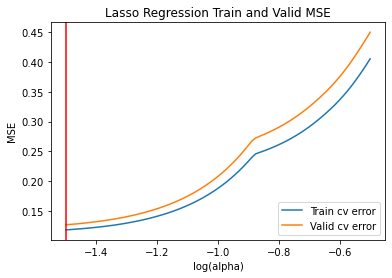

In [55]:
fig, ax = plt.subplots()
ax.plot(np.log10(alphas), train_means, label='Train cv error')
ax.plot(np.log10(alphas), valid_means, label='Valid cv error')
ax.axvline(np.log10(valid_means.idxmin()), color='red')
ax.legend()
ax.set_title('Lasso Regression Train and Valid MSE')
ax.set_xlabel('log(alpha)')
ax.set_ylabel('MSE');